![Py4Eng](img/logo.png)

# Cython: type annotation and C interface
## Yoav Ram

[Cython](http://docs.cython.org/src/userguide/numpy_tutorial.html#cython-at-a-glance) is a compiler that compiles Python-like code files to C code. Still, ‘’Cython is not a Python to C translator’‘: Cython does not take your Python program and “turns it into C”. 
Rather, the result makes full use of the Python runtime environment.
Your code is still in Python-it runs within the Python runtime environment-but rather than compiling to interpreted Python bytecode, it is compiled to native machine code, with the addition of extra syntax for easy embedding of faster C-like code.

Cython has two important consequences:

- **Speed.** How much depends very much on the program involved though. Typical Python numerical programs would tend to gain very little as most time is spent in lower-level C that is used in a high-level fashion. However for-loop-style programs can gain many orders of magnitude, when typing information is added (and is so made possible as a realistic alternative).
- **Easy calling into C code.** One of Cython’s purposes is to allow easy wrapping of C libraries. When writing code in Cython you can call into C code as easily as into Python code.

Some Python constructs are not yet supported, though making Cython compile all Python code is a stated goal (among the more important omissions are inner functions and generator functions).

# Hello world!

Let's start with a simple *Hello World!* to check that everything is working.

We load the `Cython` magic that will allow us to quickly use Cython inside the notebook.
The magic is installed with the `cython` package (`mamba install cython`, `conda install cython` or `pip install cython`).

Cython requires that a C compiler is installed and can be found, and on **Windows** that may be tricky, here are some resources:
- [Install Cython on Windows](https://github.com/cython/cython/wiki/InstallingOnWindows)
- [Install C compiler on Windows](https://github.com/cython/cython/wiki/CythonExtensionsOnWindows)
- [Compiling Python extensions on Windows](https://blog.ionelmc.ro/2014/12/21/compiling-python-extensions-on-windows/)

On **Linux/MacOS** you probably already have a compiler, check with `!clang --version` or `!gcc --version`. 
You can install `gcc`:
- On [Ubuntu](https://help.ubuntu.com/community/InstallingCompilers) you should run `sudo apt-get install build-essential`.
- On CentOS you just need to install development tools: `sudo yum group install "Development Tools"`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import Cython
print("Cython", Cython.__version__)

%load_ext Cython

Cython 3.0.12


In [2]:
%%cython 
print("Hello World!")

Hello World!


# First Cython example

Let's see a quick example of what Cython can do for us. 

Consider the following Python function that returns the first k prime numbers (but not more than 1000):

In [3]:
def find_k_primes(k):
    primes = [None] * 1000 # pre-allocate so we don't use append
    n_primes = 0  # count number of primes
    candidate = 2 
    while n_primes < min(k, 1000):
        # is candidate a prime number?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a new prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return primes[:n_primes] # only return the primes

In [4]:
assert find_k_primes(10) == [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Here is the Cython version of this function; the only addition here is that we use `cdef` to define the types of all local variabes. This `cdef` statement is used to define **local C variables**. We also add `int` in the arguments list to define the type of `k`; this means that any object passed will be **converted to a C integer**.

In [7]:
%%cython
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0 
    candidate = 2
    while n_primes < min(k, 1000):
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break 
        else: 
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return [p for p in primes[:n_primes]] # convert primes from a cython type to a python list

In [8]:
find_k_primes(100) == cfind_k_primes(100)

True

In [9]:
n = 1000
%timeit find_k_primes(n)
%timeit cfind_k_primes(n)

15.8 ms ± 197 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
493 μs ± 2.26 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Note that in the inner loop we only refer variables with type definitions, and thus C objects. 
Therefore, the loop is translated to a C loop by Cython and runs very fast.

# Creating a Cython module

We can now put that Cython code into a separate file with extension `pyx`. 

In [8]:
!mkdir ../scripts/cython
%cd ../scripts/cython

/Users/yoavram/Work/Teaching/Py4Eng/scripts/cython


In [9]:
%pwd

'/Users/yoavram/Work/Teaching/Py4Eng/scripts/cython'

In [10]:
%%file primes.pyx
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0  
    candidate = 2
    while n_primes < min(k, 1000):
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break 
        else:
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return [p for p in primes[:n_primes]] # convert primes from a cython type to a python list

Writing primes.pyx


Now we compile it and import it with a single stroke using the [`pyximport` module](http://docs.cython.org/en/stable/src/reference/compilation.html),

> Cython code, unlike Python, must be compiled.
> This happens in two stages:
> A .pyx file is compiles by Cython to a .c file.
> The .c file is compiled by a C comiler to a .so file (or a .pyd file on Windows)

In [11]:
import pyximport
pyximport.install(language_level=3)

(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x10cc85250>)

In [12]:
%pwd

'/Users/yoavram/Work/Teaching/Py4Eng/scripts/cython'

In [13]:
from primes import cfind_k_primes

In [14]:
assert cfind_k_primes(10) == [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

You can also do this on your own, without `pyximport`. This is useful when shipping or if you just want to see the C file - for example, to see how much work Cython saved you from doing!

You start by writing a `setup.py` file which imports `cythonize` from the Cython package and tells `setup` (the standard way to setup Python packages, using `distutils` or `setuptools`) to build an extension module using `cythonize`.

In [15]:
%%file setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("primes.pyx")
)

Writing setup.py


Run it with this command, which builds the extension:

In [16]:
python = os.path.join(sys.base_prefix, 'bin', 'python')
!$python setup.py build_ext --inplace

Compiling primes.pyx because it changed.
[1/1] Cythonizing primes.pyx
/Users/yoavram/miniforge3/envs/DataSciPy/lib/python3.12/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/yoavram/Work/Teaching/Py4Eng/scripts/cython/primes.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Let's see what was generated (this might look different on different machines, especially Windows vs. Linux):

In [17]:
%ls

build/                        primes.pyx
primes.c                      setup.py
primes.cpython-312-darwin.so*


And the actual C file:

In [18]:
%less primes.c

/* Generated by Cython 3.0.12 */

/* BEGIN: Cython Metadata
{
    "distutils": {
        "name": "primes",
        "sources": [
            "primes.pyx"
        ]
    },
    "module_name": "primes"
}
END: Cython Metadata */

#ifndef PY_SSIZE_T_CLEAN
#define PY_SSIZE_T_CLEAN
#endif /* PY_SSIZE_T_CLEAN */
#if defined(CYTHON_LIMITED_API) && 0
  #ifndef Py_LIMITED_API
    #if CYTHON_LIMITED_API+0 > 0x03030000
      #define Py_LIMITED_API CYTHON_LIMITED_API
    #else
      #define Py_LIMITED_API 0x03030000
    #endif
  #endif
#endif

#include "Python.h"
#ifndef Py_PYTHON_H
    #error Python headers needed to compile C extensions, please install development version of Python.
#elif PY_VERSION_HEX < 0x02070000 || (0x03000000 <= PY_VERSION_HEX && PY_VERSION_HEX < 0x03030000)
    #error Cython requires Python 2.7+ or Python 3.3+.
#else
#if defined(CYTHON_LIMITED_API) && CYTHON_LIMITED_API
#define __PYX_EXTRA_ABI_MODULE_NAME "limited"
#else
#define __PYX_EXTRA_ABI_MODULE_NAME ""
#endif
#define C

You can now import `primes` as if it was a regular Python module (if you aren't sure which of the things you are importing, restart your kernel, but don't forger to change directory to `../scripts/cython`).

Here's a small test script.

In [19]:
%%file test_primes.py
from primes import cfind_k_primes
assert cfind_k_primes(10) ==  [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Writing test_primes.py


In [20]:
%run test_primes.py

# Integration example

This is from Robert Bradshaw's [SciPy 2008 slides](http://wiki.sagemath.org/scipy08?action=AttachFile&do=get&target=scipy-cython.tgz).

We will write a simple integration code to integrate $f(x) = x^3 - 3x$.
The true result is 1/4 - 3/2 =-1.25.

In [10]:
def f(x):
    return x**3 - 3 * x

def integrate_f(a , b , N):
    s = 0
    dx = (b - a )/ N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

integrate_f(0, 1, 100000)

-1.249989999975006

In [11]:
%timeit integrate_f(0, 1, 100000)

11.5 ms ± 389 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now the same with Cython. 

When we define a function with `cdef` we can set a return value but we can only call it from within Cython. 
When we define a function with `def` we can import it and call it from Python.

Note that we change `x**3` to `x * x * x`.

In [15]:
%%cython
cdef double g(double x):
    return x * x * x - 3 * x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a )/ N
    cdef int i
    for i in range(N):
        s += g( a + i * dx )
    return s * dx

In [17]:
integrate_g(0, 1, 100000)

-1.249989999975006

In [14]:
%timeit integrate_g(0, 1, 100000)

62.6 μs ± 205 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Using C native function

Now let's integrate 
$$
\int_a^b{\frac{\sin{x}}{x}}
$$

Without Cython, we should use either `math.sin` or `numpy.sin`:

In [18]:
def f(x):
    return np.sin(x) / x

integrate_f(1, 2, 100000)

np.float64(0.6593318405457452)

With Cython, we can import some C functions using an `extern` block:

In [21]:
%%cython
cdef extern from "math.h":
    double sin(double)
    double cos(double)

cdef double g(double x):
    return sin(x)/x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a) /  N
    cdef int i
    for i in range(N):
        s += g(a + i * dx)
    return s * dx

In [22]:
integrate_g(1, 2, 100000)

0.6593318405457452

In [29]:
%timeit integrate_f(1, 3, 100000)
%timeit integrate_g(1, 3, 100000)

99.2 ms ± 509 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
899 μs ± 12.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Cython with NumPy

Cython works well with NumPy.

Let's loop over a NumPy array:

In [23]:
def summ(x):
    s = 0
    for i in range(x.shape[0]):
        s += x[i]
    return s

In [25]:
%%cython
cimport numpy as np

def csumm(long[:] x): # input type is a buffer
    cdef int i = 0
    cdef long s = 0
    cdef Py_ssize_t size = x.shape[0]
    for i in range(size):
        s += x[i]
    return s

In [26]:
x = np.random.randint(0, 9, 100000)
summ(x), csumm(x)

(np.int64(399190), 399190)

In [34]:
%timeit summ(x)
%timeit csumm(x)

13.7 ms ± 95.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.1 μs ± 686 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


If you would type `s` and `arr` as `int` you would get an error because Python's `int` is a C `long`... But you would get a `ValueError`, not a segmentation fault or anything like that. Here's an example:

In [40]:
y = np.array([0.1, 0.2, 0.3])
csumm(y)

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'

# Mandelbrot fractal

The following creates Mandelbrot's famous fractal.

In [22]:
import numpy as np

def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

CPU times: user 620 ms, sys: 2.99 ms, total: 623 ms
Wall time: 622 ms


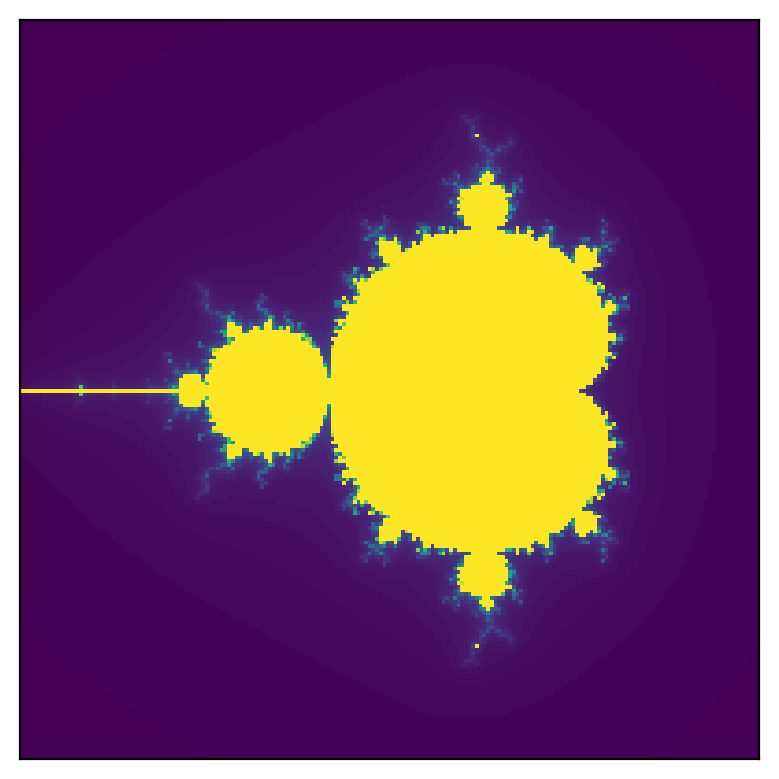

In [23]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)
%time mandelbrot(m, size, iterations)
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

It's a long computation with three nested loopes, let's see if Cython can make it better.
Here, we introduce type defs for everything we can, and we remove `np.abs` in favor of manual computation of the norm of `z` (and using `np` leads to a function that has the same runtime as the above Python version).

In [19]:
%%cython
def cmandelbrot(int[:,:] m, int size, int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real*z.real + z.imag*z.imag <= 100:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [5]:
%timeit mandelbrot(m, size, iterations)
%timeit cmandelbrot(m, size, iterations)

640 ms ± 6.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.71 ms ± 15.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Parallelization

We can use `prange` for easy [multi-threading of for loops with Cython](https://cython.readthedocs.io/en/stable/src/userguide/parallelism.html). 
However, this uses OpenMP, which has to be setup with the C compiler.
Otherwise, you will not see any improvements. 
I leave the relevant code here, but instead of trying to install a compiler with OpenMP (which I don't have), I will come back to this in the Numba session.

In [15]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp
from cython.parallel import prange

def pmandelbrot(int[:,:] m, int size, int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in prange(size, nogil=True):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real*z.real + z.imag*z.imag <= 100:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

Content of stderr:
clang: error: unsupported option '-fopenmp'

In [5]:
size = 1000
iterations = 1000
m = np.zeros((size, size), dtype=np.int32)

In [ ]:
%timeit cmandelbrot(m, size, iterations)
%timeit pmandelbrot(m, size, iterations)

# Exercise: difference matrix

Write a Cython function that calculates the difference matrix for a given array.
Compare it to the NumPy implementation.

In [10]:
def diff_mat(x):
    return x.reshape(-1, 1) - x

In [95]:
x = np.random.random(10000)
assert np.allclose(diff_mat(x), cdiff_mat(x))
%timeit diff_mat(x)
%timeit cdiff_mat(x)

455 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
496 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Image segmentation

Let's do another example in which we segment images - turn a grayscale image into a binary image.


In [100]:
import imageio
from skimage.transform import resize

def display_image(im):
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [48]:
%cd ../../sessions

/Users/yoavram/Work/Teaching/Py4Eng/sessions


Let's do a segmentation demonstration.

(dtype('float64'), (900, 944), np.float64(0.0), np.float64(255.0))

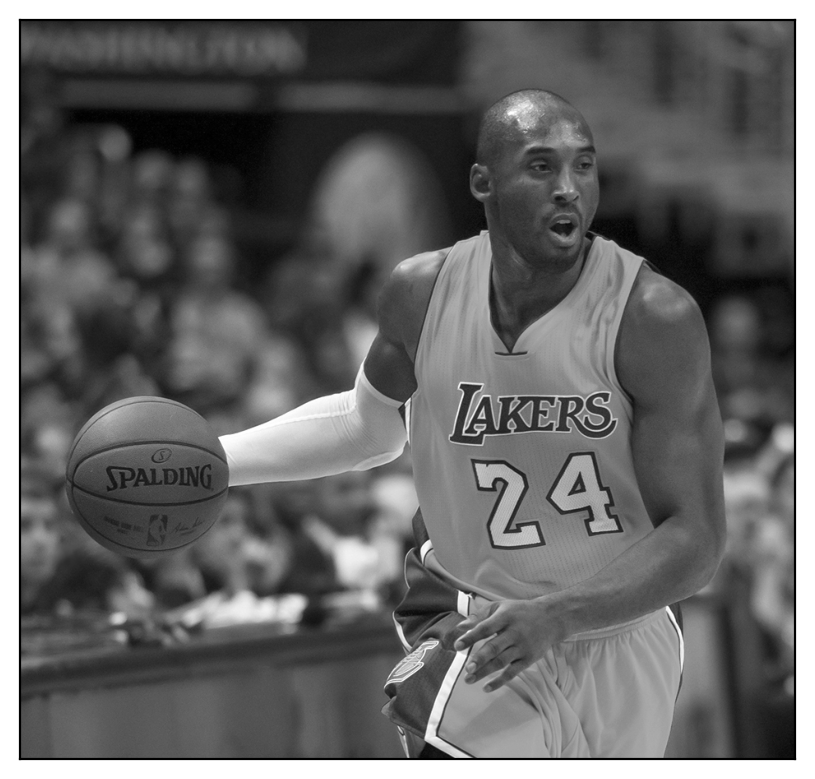

In [101]:
# original image from https://upload.wikimedia.org/wikipedia/commons/5/56/Kobe_Bryant_2014.jpg
image = imageio.v2.imread('../data/Kobe_Bryant_2014.jpg')
image = image.mean(axis=2) # greyscale
display_image(image)
image.dtype, image.shape, image.min(), image.max()

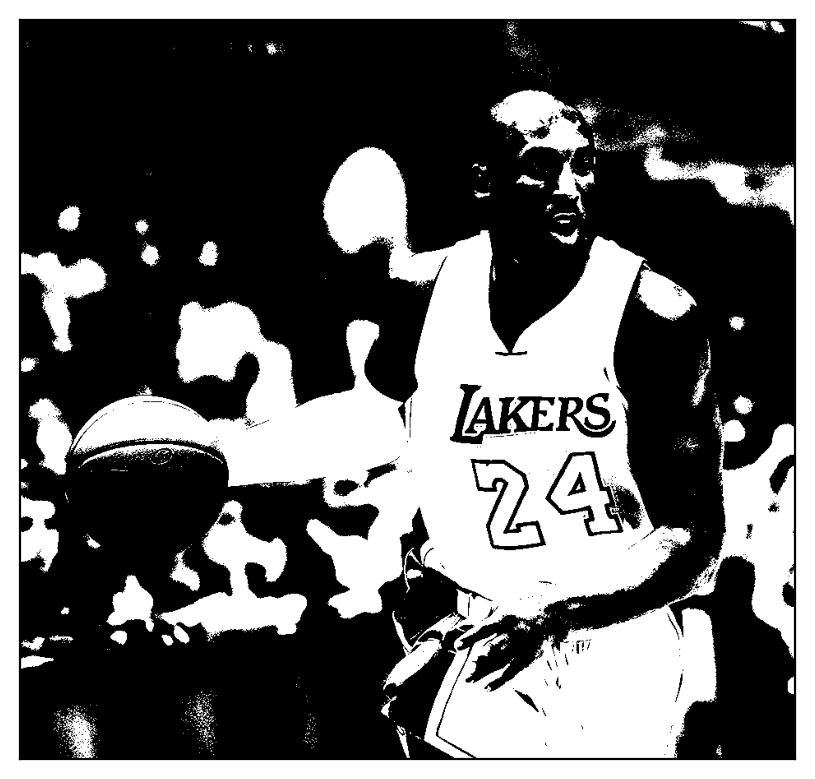

In [102]:
def segment(image, threshold=100):
    output = np.zeros_like(image)
    output[image > threshold] = 255
    return output

display_image(segment(image))

In our Cython version, we have two function:
- `_segment` that takes both the input and output arrays as arguments and uses loops for the segmentation. We wrap it with `boundscheck(False)`, a [Cython directive](https://github.com/cython/cython/wiki/enhancements-compilerdirectives) that improves runtime.
- `csegment` that just creates an output array for the input array and calls `_segment`.

This separation helps the compiler; putting everything in one function results in reduced speed.

In [103]:
%%cython
import numpy as np
import cython 

@cython.boundscheck(False) 
cdef int _segment(double[:,:] image, int n, int m,
                  double threshold, double[:,:] output): 
    cdef int i, j
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0

def csegment(image, threshold=100):
    output = np.zeros_like(image)
    n, m = image.shape
    _segment(image, n , m, threshold, output)
    return output

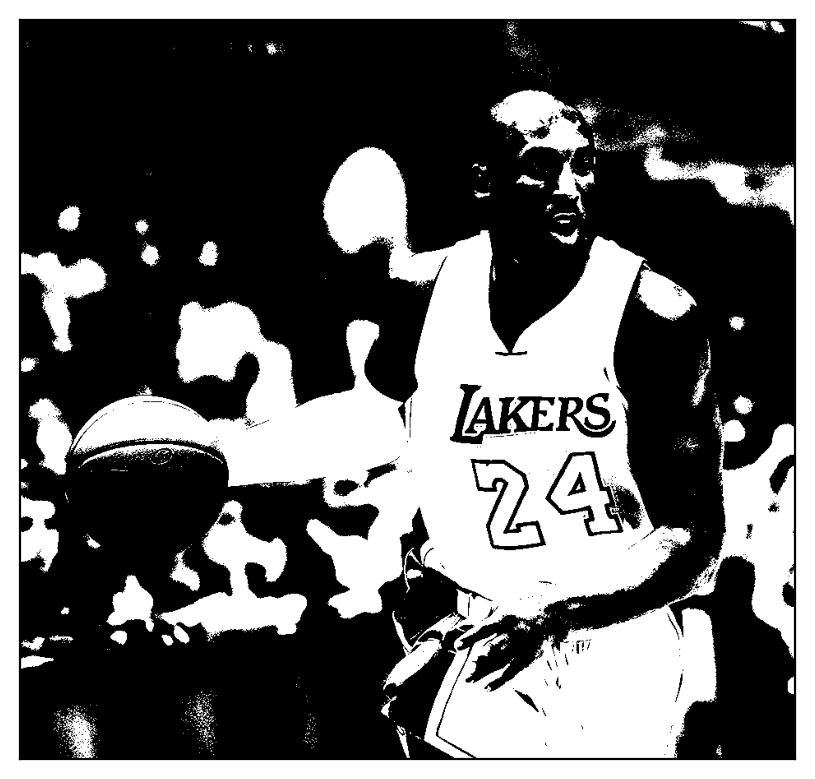

In [104]:
display_image(csegment(image))

In [105]:
%timeit -n 10 -r 5 segment(image)
%timeit -n 10 -r 5 csegment(image)

972 μs ± 406 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)
333 μs ± 19.2 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)


So on a single image Cython is 2-3-fold faster. 
What about segmenting a bunch of images?

Let's download the 30 examples images from the [Berkeley Segmentation Dataset](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/test-001-025.html).

![example](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg)

In [51]:
image_urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/{:d}.jpg'.format(i)
    for i in [119082,170057,58060,163085,42049,167062,157055,295087,24077,78004,220075,45096,38092,43074,16077,86000,101085,219090,89072,300091,126007,156065,76053,296007,175032]
]
image_urls[0]

'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/119082.jpg'

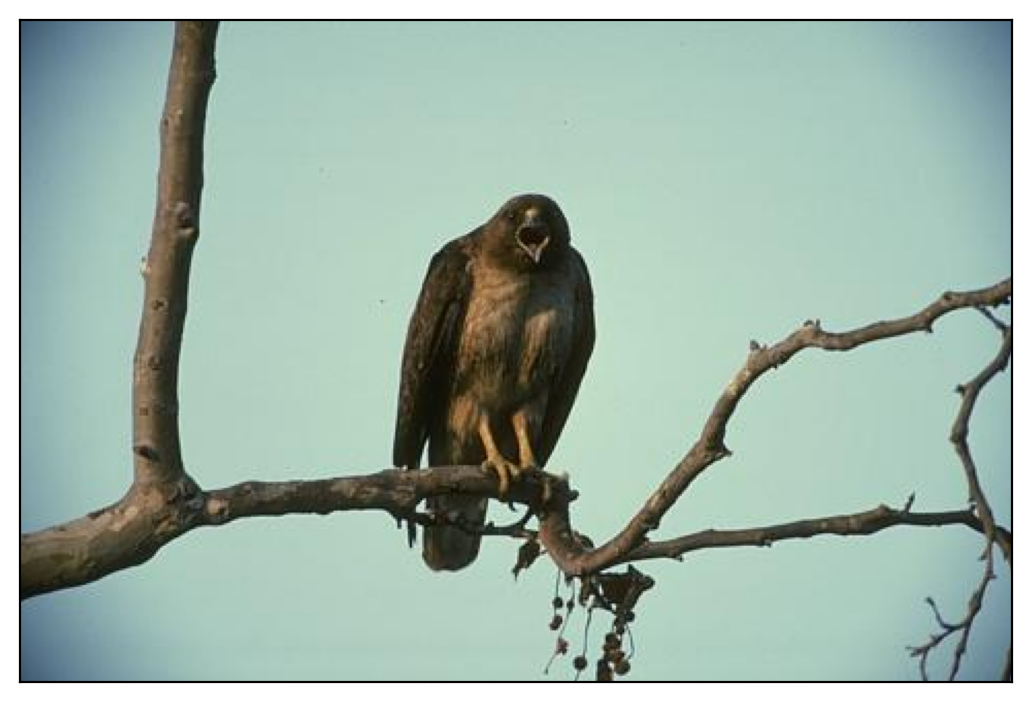

In [52]:
display_image(imageio.v2.imread(image_urls[4]))

Let's load and flatten the images:

In [53]:
images = [imageio.v2.imread(url) for url in image_urls] # load
images = [im.mean(axis=2) for im in images] # flatten to bnw

Compare the NumPy and Cython versions:

In [99]:
%timeit -n 10 -r 5 [segment(im) for im in images]
%timeit -n 10 -r 5 [csegment(im) for im in images]

4.41 ms ± 1.58 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
1.21 ms ± 10.5 μs per loop (mean ± std. dev. of 5 runs, 10 loops each)


A nice improvement!


# References

- [Cython language basics](http://docs.cython.org/src/userguide/language_basics.html#language-basics)
- [Cython for NumPy users](http://docs.cython.org/src/userguide/numpy_tutorial.html#numpy-tutorial) offers a 2D convolve example.
- [IPython Cookbook](https://ipython-books.github.io/cookbook/) by Cyrille Rossant has a full chapter on high performance computing. with many [notebook examples](https://github.com/ipython-books/cookbook-code/tree/master/notebooks/chapter05_hpc) and a more complicated Cython example.
- Jake Vanderplas's [Cython project template](https://github.com/jakevdp/cython_template) can help you build projects that use Cython.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com). 

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)